In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib widget

In [4]:
import sys, os, pathlib
import numpy as np
import torch

import warp as wp
wp.config.quiet = True
wp.set_device('cpu')

sys.path.append('../..')
import project
from project.core.utils import pprint

torch.cuda.is_available()

True

In [5]:
!nvidia-smi

Mon Feb  2 21:20:37 2026       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.35.03              Driver Version: 560.35.03      CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA RTX A6000               On  |   00000000:01:00.0 Off |                  Off |
| 30%   35C    P8             22W /  300W |       5MiB /  49140MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [7]:
config = project.core.fileio.load_config('2026-01-15_config.yaml')

#config['dataset']['examples']['subjects'] = 'one_subject.csv'
config['dataset']['examples']['subjects'] = 'ten_subjects.csv'
#config['dataset']['examples']['subjects'] = '2026-01-26_preprocessed.csv'

config['dataset']

Loading 2026-01-15_config.yaml


{'name': 'ShapeNet',
 'root': '/ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem',
 'examples': {'subjects': 'ten_subjects.csv', 'variant': '2026-01-15'},
 'metadata': {'parse_metadata': True,
  'unit_policy': 'prefer_metadata',
  'default_unit': 0.01},
 'selectors': {'material_mask': 'uniform-seed'}}

In [8]:
examples = project.api.get_examples(config['dataset'])
len(examples)

Gathering examples


10

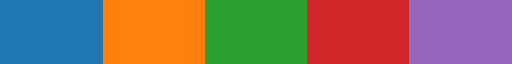

In [9]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
n_labels = 5
colors = plt.get_cmap('tab10').colors
cmap = ListedColormap(colors[:n_labels])

cmap.set_under('white')
cmap.set_over('black')
cmap.set_bad('black')
cmap

Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/100f39dce7690f59efb94709f30ce0d2/images/mask_regions_uniform-seed_image.nii.gz
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/100f39dce7690f59efb94709f30ce0d2/masks/mask_regions_uniform-seed.nii.gz
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/100f39dce7690f59efb94709f30ce0d2/fields/mask_regions_uniform-seed_elastic.nii.gz


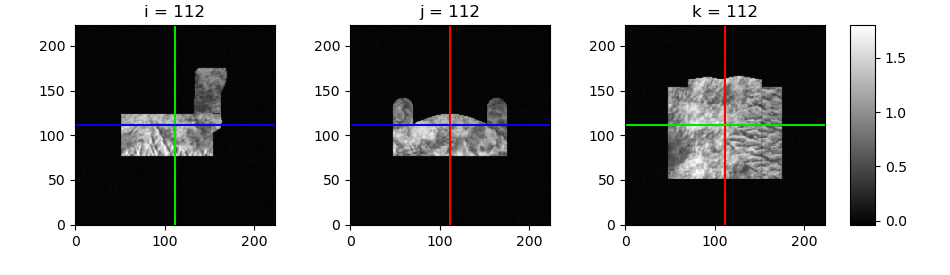

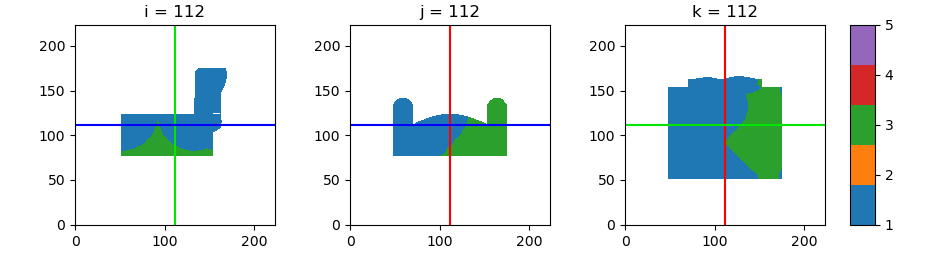

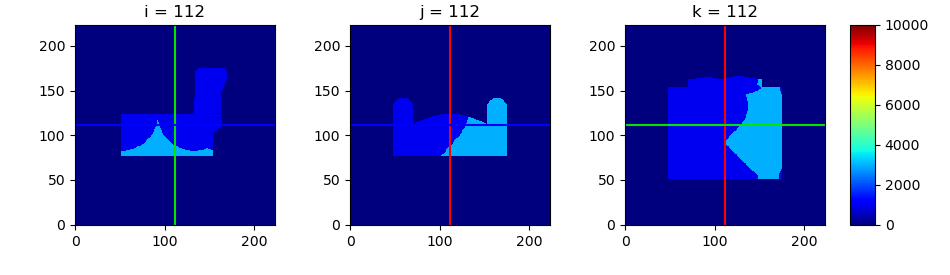

In [10]:
import project.visual.matplotlib

ex = examples[0]
image = project.core.fileio.load_nibabel(ex.paths['input_image'])
project.visual.matplotlib.SliceViewer(image.get_fdata(), cmap='gray')

mask = project.core.fileio.load_nibabel(ex.paths['material_mask'])
project.visual.matplotlib.SliceViewer(mask.get_fdata(), cmap=cmap, vmin=1, vmax=5)

E_true = project.core.fileio.load_nibabel(ex.paths['elastic_field'])
project.visual.matplotlib.SliceViewer(E_true.get_fdata(), cmap='jet', vmin=0, vmax=1e4)

In [11]:
train_config = config['training'].copy()
project.core.utils.pprint(train_config, 2, 100)

dict(len=8)
├── 'split':           dict(len=4)
|   ├── 'key':        'category'
|   ├── 'test_ratio': 0.2
|   ├── 'val_ratio':  0.1
|   └── 'seed':       0
├── 'transform':       dict(len=4)
|   ├── 'normalize':  True
|   ├── 'image_mean': 1.0
|   ├── 'image_std':  1.0
|   └── 'apply_mask': True
├── 'loader':          dict(len=4)
|   ├── 'batch_size':  1
|   ├── 'shuffle':     True
|   ├── 'num_workers': 0
|   └── 'pin_memory':  True
├── 'model':           dict(len=2)
|   ├── 'backbone': dict(len=11)
|   └── 'head':     dict(len=5)
├── 'physics_adapter': dict(len=5)
|   ├── 'nu_value':      0.4
|   ├── 'rho_bias':      1000
|   ├── 'rho_known':     True
|   ├── 'scalar_degree': 1
|   └── 'vector_degree': 1
├── 'pde_solver':      dict(len=2)
|   ├── '_class':        'WarpFEMSolver'
|   └── 'tv_reg_weight': 0.0001
├── 'optimizer':       dict(len=2)
|   ├── '_class': 'AdamW'
|   └── 'lr':     0.0001
└── 'trainer':         dict(len=2)
    ├── 'mode':       'u_sim'
    └── 'num_epochs': 20


In [12]:
import project.training
split_kws = train_config['split']
train_ex, test_ex, val_ex = project.training.split_on_metadata(examples, **split_kws)

len(train_ex), len(test_ex), len(val_ex)

Splitting examples
Test categories: {'CurioCabinet', 'Computer', 'ChestOfDrawers', 'Cabinet'}
Test subjects:   {'wss.18efc77e6837f7d311e76965808086c8', 'wss.1029fd5d71a06ea32ea98d69e91ba870'}
Train subjects: {'wss.18f4a9ed04407da57bd55ed4ce08f048', 'wss.133c16fc6ca7d77676bb31db0358e9c6', 'wss.107637b6bdf8129d4904d89e9169817b', 'wss.1644df5fbb3b926029e82c550aa06a9d', 'wss.100f39dce7690f59efb94709f30ce0d2', 'wss.13b48456dad49f8762edbb9e1af21a03', 'wss.102a6b7809f4e51813842bc8ef6fe18'}
Val subjects:   {'wss.101354f9d8dede686f7b08d9de913afe'}


(7, 2, 1)

In [13]:
%autoreload
import project.datasets.torch

collate_fn = project.datasets.torch.collate_fn
train_set = project.datasets.torch.TorchDataset(train_ex)
train_loader = torch.utils.data.DataLoader(train_set, collate_fn=collate_fn, batch_size=1)
stats = project.datasets.torch.accumulate_stats(train_loader, keys=['image', 'E', 'log_E'])
stats

Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/100f39dce7690f59efb94709f30ce0d2/images/mask_regions_uniform-seed_image.nii.gz
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/100f39dce7690f59efb94709f30ce0d2/masks/mask_regions_uniform-seed.nii.gz
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/100f39dce7690f59efb94709f30ce0d2/meshes/mask_regions_uniform-seed_image_tetmesh_mat_int.xdmf
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/100f39dce7690f59efb94709f30ce0d2/fields/mask_regions_uniform-seed_elastic.nii.gz
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/102a6b7809f4e51813842bc8ef6fe18/images/mask_regions_uniform-seed_image.nii.gz
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/102a6b7809f4e51813842bc8ef6fe18/masks/mask_regions_uniform-seed.nii.gz
Loading /ocean/p

defaultdict(<function project.datasets.torch.accumulate_stats.<locals>.<lambda>()>,
            {'image': {'count': 2877164,
              'sum': 2753154.015625,
              'sumsq': 3017902.6875,
              'min': 0.15268740057945251,
              'max': 2.3434574604034424,
              'mean': 0.9568985346768554,
              'var': 0.1332609626037088,
              'std': 0.3650492605165894},
             'E': {'count': 2877164,
              'sum': 9481425760.0,
              'sumsq': 51253667954688.0,
              'min': 1000.0,
              'max': 9000.0,
              'mean': 3295.406782512224,
              'var': 6954248.418685164,
              'std': 2637.090900724729},
             'log_E': {'count': 2877164,
              'sum': 9724518.40625,
              'sumsq': 33219569.5,
              'min': 3.0,
              'max': 3.954242467880249,
              'mean': 3.379897150892337,
              'var': 0.12223753839389673,
              'std': 0.3496248537988922

In [14]:
transform_kws = train_config['transform']
project.core.utils.pprint(transform_kws)

dict(len=4)
├── 'normalize':  True
├── 'image_mean': 1.0
├── 'image_std':  1.0
└── 'apply_mask': True


In [15]:
%autoreload
import project.datasets.torch

train_set = project.datasets.torch.TorchDataset(train_ex, **transform_kws)
test_set = project.datasets.torch.TorchDataset(test_ex, **transform_kws)
val_set = project.datasets.torch.TorchDataset(val_ex, **transform_kws)

In [16]:
loader_kws = train_config['loader']
loader_kws['batch_size'] = 2

collate_fn = project.datasets.torch.collate_fn
train_loader = torch.utils.data.DataLoader(train_set, collate_fn=collate_fn, **loader_kws)

if test_set:
    test_loader = torch.utils.data.DataLoader(test_set, collate_fn=collate_fn, **loader_kws)
else:
    test_loader = None

if val_set:
    val_loader = torch.utils.data.DataLoader(val_set, collate_fn=collate_fn, **loader_kws)
else:
    val_loader = None


In [17]:
%autoreload
import project.models
import copy

model_kws = copy.deepcopy(train_config['model'])

backbone_kws = model_kws['backbone']
backbone_kws['_class'] = 'UNet3D'
backbone_kws['conv_channels'] = 16
backbone_kws['n_enc_blocks']  = 5
backbone_kws['n_conv_units']  = 2
backbone_kws['n_init_units']  = 2
backbone_kws['kernel_size']   = 3
backbone_kws['relu_leak']     = 0.1
backbone_kws['norm_type']     = 'group'
backbone_kws['num_groups']    = 4
backbone_kws['upsample_mode'] = 'trilinear'

head_kws = model_kws['head']
head_kws['_class'] = 'ElasticityHead'
head_kws['logE_mean'] = 3.5
head_kws['logE_std']  = 0.3
head_kws['logE_min']  = 0.0
head_kws['logE_max']  = 6.0

project.core.utils.pprint(model_kws)

model = project.models.build_model(model_kws)

dict(len=2)
├── 'backbone': dict(len=11)
|   ├── '_class':        'UNet3D'
|   ├── 'conv_channels': 16
|   ├── 'n_enc_blocks':  5
|   ├── 'n_conv_units':  2
|   ├── 'n_init_units':  2
|   ├── 'kernel_size':   3
|   ├── 'relu_leak':     0.1
|   ├── 'norm_type':     'group'
|   ├── 'num_groups':    4
|   ├── 'pooling_type':  'max'
|   └── <1 more items>
└── 'head':     dict(len=5)
    ├── '_class':    'ElasticityHead'
    ├── 'logE_mean': 3.5
    ├── 'logE_std':  0.3
    ├── 'logE_min':  0.0
    └── 'logE_max':  6.0


In [18]:
import project.physics

pde_solver_kws = train_config['pde_solver'].copy()
pde_solver_cls = pde_solver_kws.pop('_class')

physics_adapter = project.physics.PhysicsAdapter(
    pde_solver_cls=pde_solver_cls,
    pde_solver_kws=pde_solver_kws,
    **train_config['physics_adapter']
)
physics_adapter

In [19]:
optimizer_kws = train_config['optimizer'].copy()
optimizer_kws['lr'] = 5e-5
optimizer_cls = getattr(torch.optim, optimizer_kws.pop('_class'))
optimizer = optimizer_cls(model.parameters(), **optimizer_kws)

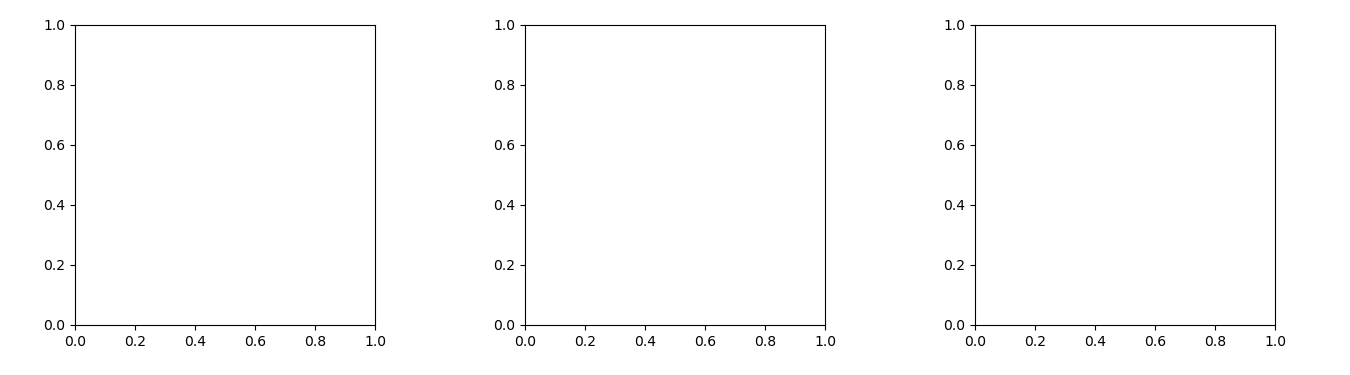

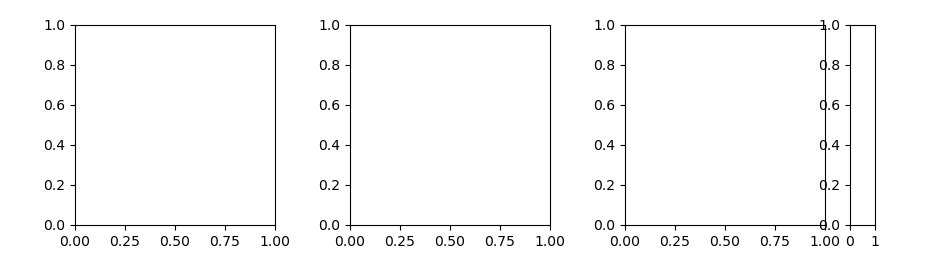

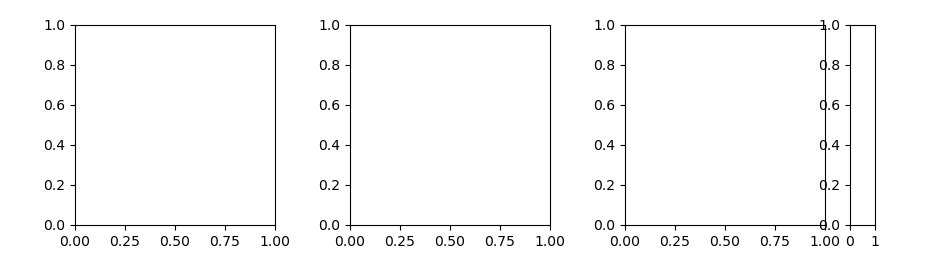

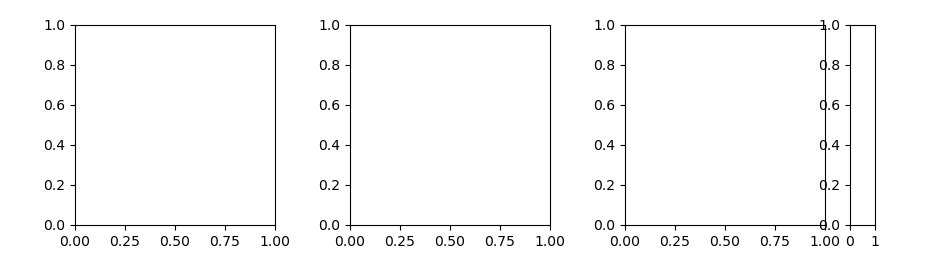

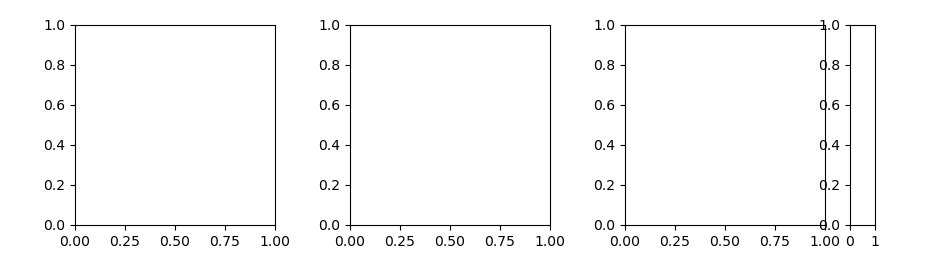

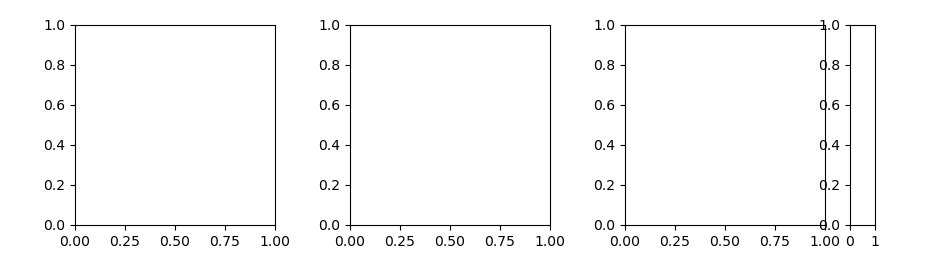

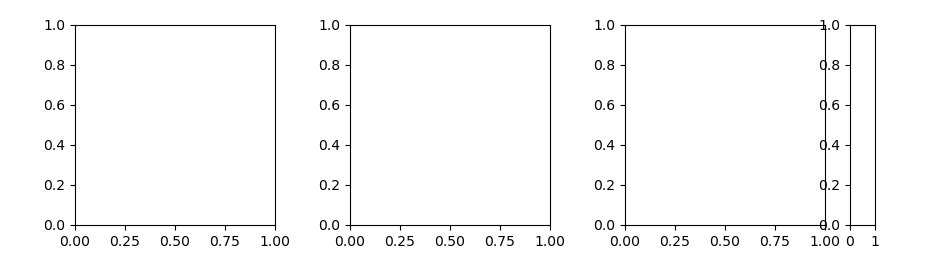

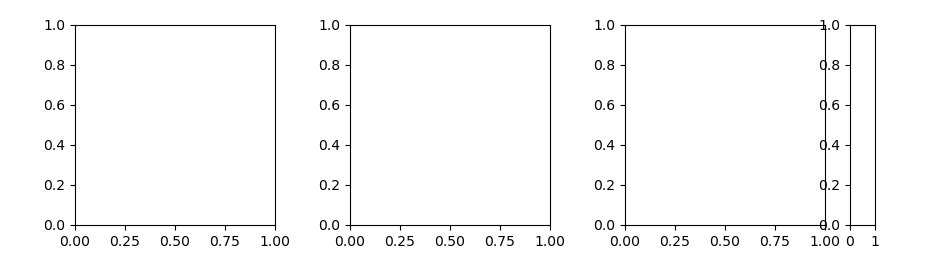

In [20]:
%autoreload
import project.training
import project.evaluation

trainer_kws = train_config['trainer'].copy()
trainer_kws['mode'] = 'u_sim' #'logE_reg'

trainer = project.training.Trainer(
    model=model,
    optimizer=optimizer,
    physics_adapter=physics_adapter,
    train_loader=train_loader,
    test_loader=test_loader,
    val_loader=val_loader,
    callbacks=[
        project.evaluation.LoggerCallback(),
        project.evaluation.PlotterCallback(keys=['loss', 'E_pred', 'E_true']),
        project.evaluation.ViewerCallback(keys=['image', 'E_pred', 'E_true', 'mat_pred_a', 'mat_pred_r', 'mat_pred_o', 'mat_true']),
        project.evaluation.EvaluatorCallback()
    ],
    train_mode=trainer_kws.pop('mode')
)

In [ ]:
#trainer.load_state(epoch=20)
trainer.train(num_epochs=500, val_every=0)

Start training loop
===== Epoch 0 =====
Saving checkpoints/checkpoint00000.pt
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/102a6b7809f4e51813842bc8ef6fe18/images/mask_regions_uniform-seed_image.nii.gz
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/102a6b7809f4e51813842bc8ef6fe18/masks/mask_regions_uniform-seed.nii.gz
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/102a6b7809f4e51813842bc8ef6fe18/meshes/mask_regions_uniform-seed_image_tetmesh_mat_int.xdmf
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/102a6b7809f4e51813842bc8ef6fe18/fields/mask_regions_uniform-seed_elastic.nii.gz
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/18f4a9ed04407da57bd55ed4ce08f048/images/mask_regions_uniform-seed_image.nii.gz
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/18f4a9ed0440

/ocean/projects/asc170022p/mtragoza/lung-project/notebooks/shapenet/../../project/evaluation.py:144: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self.fig.tight_layout()
/ocean/projects/asc170022p/mtragoza/lung-project/notebooks/shapenet/../../project/visual/matplotlib.py:99: UserWarning: Adding colorbar to a different Figure <Figure size 950x275 with 4 Axes> than <Figure size 950x275 with 4 Axes> which fig.colorbar is called on.
  plt.colorbar(self.im_k, cax=self.cbar_ax)


Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/100f39dce7690f59efb94709f30ce0d2/images/mask_regions_uniform-seed_image.nii.gz
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/100f39dce7690f59efb94709f30ce0d2/masks/mask_regions_uniform-seed.nii.gz
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/100f39dce7690f59efb94709f30ce0d2/meshes/mask_regions_uniform-seed_image_tetmesh_mat_int.xdmf
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/100f39dce7690f59efb94709f30ce0d2/fields/mask_regions_uniform-seed_elastic.nii.gz
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/1644df5fbb3b926029e82c550aa06a9d/images/mask_regions_uniform-seed_image.nii.gz
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/1644df5fbb3b926029e82c550aa06a9d/masks/mask_regions_uniform-seed.nii.gz
Loading /ocean

In [21]:
import project.visual.matplotlib
import matplotlib.pyplot as plt

def colormap(name, n=None, under=None):
    cmap = plt.get_cmap('jet', n)
    if under:
        cmap.set_under(under)
    return cmap

mm = mask[0][0].detach().cpu().numpy()
im = image[0][0].detach().cpu().numpy()
Ep = E_pred[0][0].detach().cpu().numpy()
Et = E_true[0][0].detach().cpu().numpy()

_ = project.visual.matplotlib.show_image_slices(mm, cmap=colormap('jet', 9, under='white'), clim=(1,9), colors='cmy')
_ = project.visual.matplotlib.show_image_slices(im, cmap='gray', clim=(0,1))
_ = project.visual.matplotlib.show_image_slices(Ep, cmap=colormap('jet'), clim=(0,1e4), colors='cmy')
_ = project.visual.matplotlib.show_image_slices(Et, cmap=colormap('jet'), clim=(0,1e4), colors='cmy')

TypeError: Cannot slice image objects; consider using `img.slicer[slice]` to generate a sliced image (see documentation for caveats) or slicing image array data with `img.dataobj[slice]` or `img.get_fdata()[slice]`

In [ ]:
def postprocess(x, lo, hi, eps=1e-5):
    x = np.asarray(x)
    x = np.maximum(x, eps)
    x = np.log10(x)
    x = np.clip(x, lo, hi)
    return x

lo, hi = (0, 5)
n_bins = 500

pp = postprocess(Ep, lo, hi)
pt = postprocess(Et, lo, hi)

cmap = colormap('jet', n_bins, under='black')

_ = project.visual.matplotlib.show_image_slices(pp, clim=(lo, hi), cmap=cmap, colors='cmy')
_ = project.visual.matplotlib.show_image_slices(pt, clim=(lo, hi), cmap=cmap, colors='cmy')

10.0


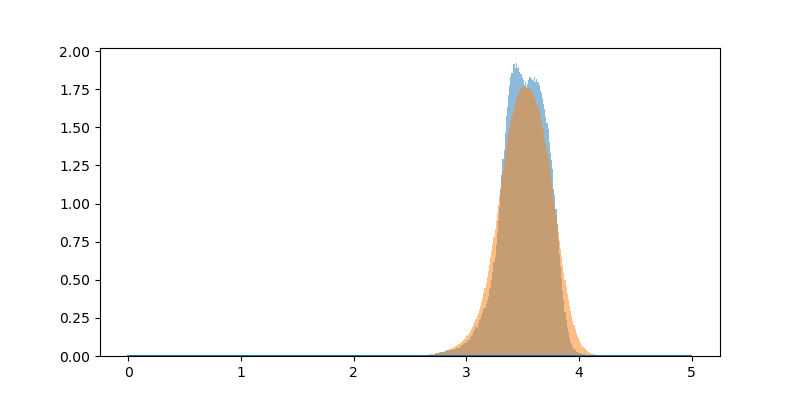

In [251]:
sigma_w = 0.1
spacing = (hi - lo) / n_bins
sigma = sigma_w / spacing
print(sigma)

hist, edges = np.histogram(pp[mm>0], bins=np.linspace(lo, hi, n_bins + 1), density=True)
dens = scipy.ndimage.gaussian_filter1d(hist, sigma=sigma, mode='nearest')

import sklearn
clustering = sklearn.cluster.AgglomerativeClustering(n_clusters=1)
labels = clustering.fit_predict(dens.reshape(-1, 1))

left = edges[:-1]
right = edges[1:]
width = right - left

fig, ax = plt.subplots(figsize=(8,4))

_ = ax.bar(left, hist, width, align='edge', alpha=0.5)
_ = ax.bar(left, dens, width, align='edge', alpha=0.5)
_ = ax.plot(left, labels)